pip install yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

### The closing price is already adjusted close in Yfinance lib

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'NFLX']
data = yf.download(tickers, period = '5y')['Close']
data = data.dropna(how='all').ffill()
data

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,
2020-12-31,129.167389,162.846497,86.941917,271.265137,213.420837,54.073002,13.018392,235.223328
2021-01-04,125.974472,159.331497,85.768723,267.074402,208.882233,52.285999,13.076727,243.256668
2021-01-05,127.531982,160.925507,86.397995,269.090271,209.083694,52.080002,13.367158,245.036667
2021-01-06,123.239059,156.919006,86.118599,261.483429,203.662323,50.049000,12.579123,251.993332
2021-01-07,127.444389,158.108002,88.697250,266.875732,209.457932,50.889000,13.306579,272.013336
...,...,...,...,...,...,...,...,...
2025-12-23,272.359985,232.139999,315.679993,664.940002,486.850006,93.500000,189.210007,485.559998
2025-12-24,273.809998,232.380005,315.670013,667.549988,488.019989,93.639999,188.610001,485.399994
2025-12-26,273.399994,232.520004,314.959991,663.289978,487.709991,94.470001,190.529999,475.190002


### Making a Func that returns P-Value and Hedge Ratio(beta)

In [3]:
def coint(series_a,series_b):
    # A. ALIGN DATA
    # We join them to ensure dates match perfectly
    df = pd.concat([series_a, series_b], axis=1, join='inner')
    df.columns = ['Y', 'X']
    # B. RUN OLS (Find the Hedge Ratio)
    X_const = sm.add_constant(df['X'])
    model = sm.OLS(df['Y'], X_const).fit()
    beta = model.params.iloc[1]
    # C. CALCULATE SPREAD
    # Spread = Y - (Beta * X)
    spread = df['Y'] - (beta * df['X'])

    # D. RUN ADF TEST (Check for Stationarity)
    # adfuller returns a tuple. Index 1 is the p-value.
    adf_result = adfuller(spread)
    p_value = adf_result[1]

    return p_value, beta

### Checking every combination in list(ticker) for Co-integraion

In [4]:
results = [] # to store results
pairs = list(combinations(tickers, 2)) # create all possible unique pairs 
for stock1, stock2 in pairs:
    prices_s1 = data[stock1]
    prices_s2 = data[stock2]

    # Get the p-value and Beta
    p_value, beta = coint(prices_s1, prices_s2)
    # Save results
    results.append({
        'Stock A': stock1,
        'Stock B': stock2,
        'P-Value': round(p_value, 4),
        'Hedge Ratio': round(beta, 3)
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='P-Value')

# Filter for "Significant" pairs (P-Value < 0.05)
passing_pairs = results_df[results_df['P-Value'] < 0.05]

print("\n--- RESULTS ---")
print(f"Tested {len(pairs)} pairs.")
print(f"Found {len(passing_pairs)} cointegrated pairs.")
print("\nTop 5 Candidates:")
print(results_df.head(5))


--- RESULTS ---
Tested 28 pairs.
Found 5 cointegrated pairs.

Top 5 Candidates:
   Stock A Stock B  P-Value  Hedge Ratio
19    AMZN    META   0.0057        0.198
3     AAPL    NVDA   0.0068        0.640
9     MSFT    NVDA   0.0201        1.485
21    AMZN    NFLX   0.0423        1.214
26    META    NFLX   0.0451        5.938


#### Plotting the best pair

Visualizing the spread for: AMZN vs META (Beta: 0.198)


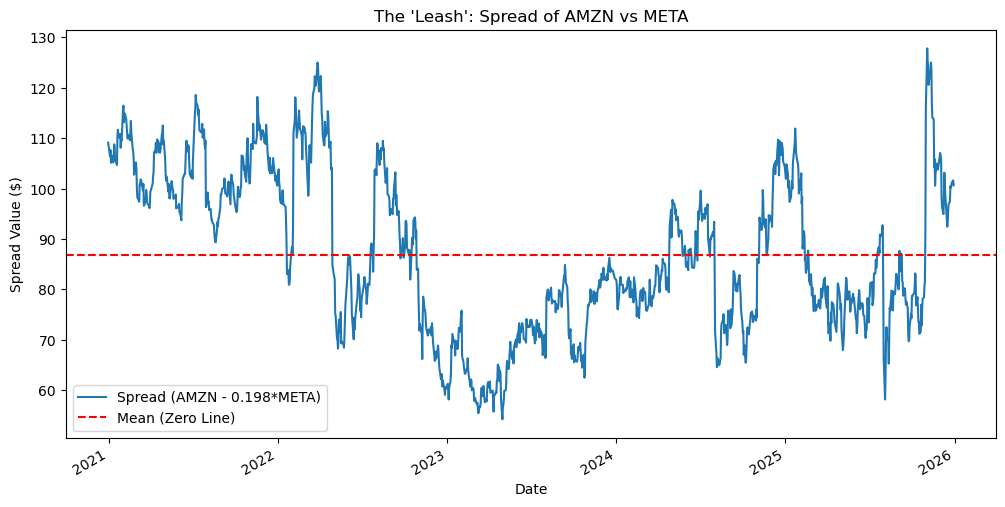

In [5]:
import matplotlib.pyplot as plt

# Get the row with the lowest P-Value (the most "connected" pair)
best_pair = results_df.iloc[0]
stock1 = best_pair['Stock A']
stock2 = best_pair['Stock B']
beta = best_pair['Hedge Ratio']

print(f"Visualizing the spread for: {stock1} vs {stock2} (Beta: {beta})")

# We need to recreate the math for this specific pair to plot it
# Spread = Price_A - (Beta * Price_B)
spread = data[stock1] - (beta * data[stock2])

# Plotting
plt.figure(figsize=(12, 6))
spread.plot(label=f'Spread ({stock1} - {beta}*{stock2})')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean (Zero Line)')
plt.legend()
plt.title(f"The 'Leash': Spread of {stock1} vs {stock2}")
plt.ylabel("Spread Value ($)")
plt.show()

### Calculation Z - score

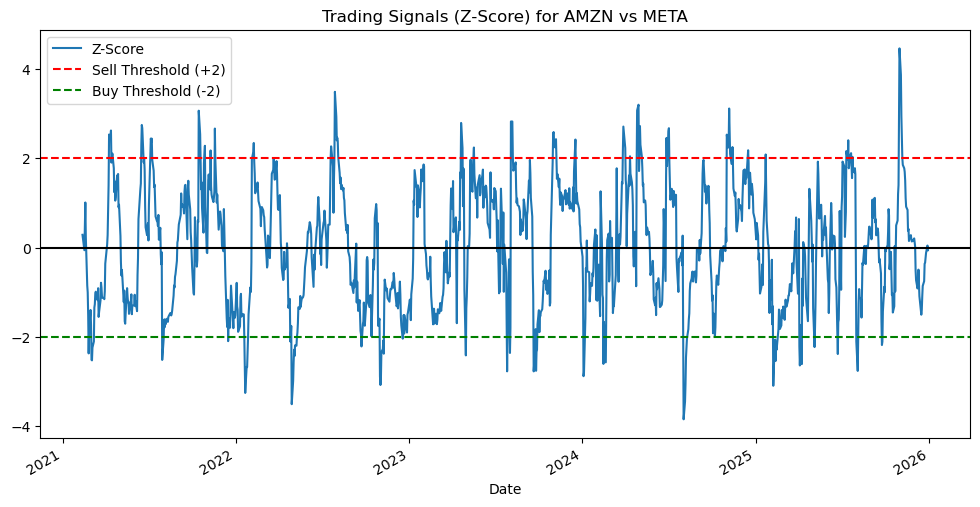

In [6]:
# We use a 30-day moving window to calculate the "Normal"
window = 30

# Calculate the mean and std dev strictly using PAST data
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Z-SCORE
# Formula: (Current Value - Average) / Volatility
zscore = (spread - rolling_mean) / rolling_std

# Plotting
plt.figure(figsize=(12, 6))
zscore.plot(label='Z-Score')

plt.axhline(0, color='black', linestyle='-')
plt.axhline(2.0, color='red', linestyle='--', label='Sell Threshold (+2)')
plt.axhline(-2.0, color='green', linestyle='--', label='Buy Threshold (-2)')

plt.legend()
plt.title(f"Trading Signals (Z-Score) for {stock1} vs {stock2}")
plt.show()

### The Buying and Selling Logic

Simulating trades with Safety Net...
Simulation Complete.


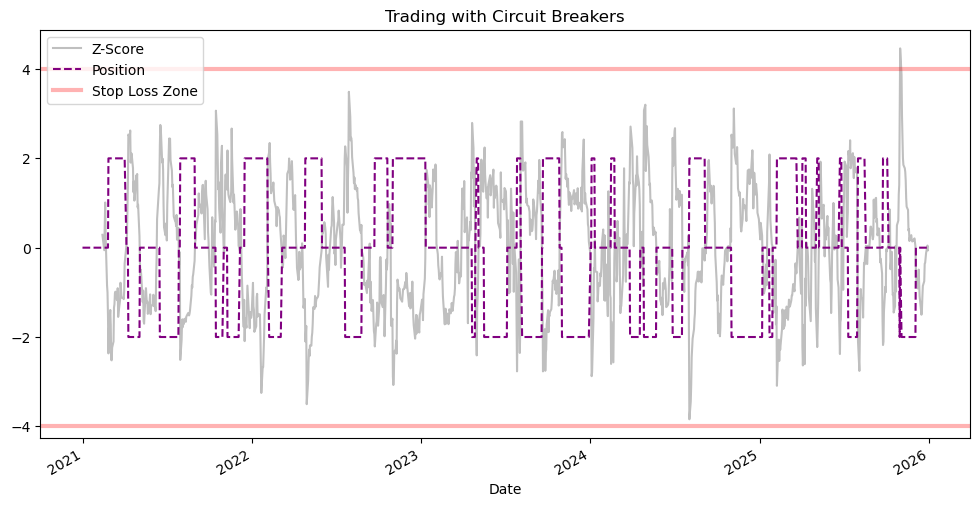

In [7]:
trades = pd.DataFrame(index=zscore.index)
trades['Z_Score'] = zscore
trades['Position'] = 0

status = 0  
entry_threshold = 2
exit_threshold = 0.0
stop_loss_threshold = 4.0  # THE EMERGENCY EXIT

print("Simulating trades with Safety Net...")

for i in range(len(trades)):
    z = trades['Z_Score'].iloc[i]
    
    # CASE 1: NO POSITION (Look for Entry)
    if status == 0:
        if z < -entry_threshold:      
            status = 1           # Buy Signal (Long Spread)
        elif z > entry_threshold:     
            status = -1          # Sell Signal (Short Spread)

    # CASE 2: LONG POSITION 
    elif status == 1:
        if z >= exit_threshold:       
            status = 0           # Profit Take
        elif z < -stop_loss_threshold: 
            status = 0           # STOP LOSS! (Spread crashed too far down)
            
    # CASE 3: SHORT POSITION 
    elif status == -1:
        if z <= exit_threshold:                
            status = 0           # Profit Take
        elif z > stop_loss_threshold:
            status = 0           # STOP LOSS! (Spread ripped too high up)

    # RECORD POSITION
    trades.loc[trades.index[i], 'Position'] = status

print("Simulation Complete.")

# Visualize the Stops
plt.figure(figsize=(12, 6))
trades['Z_Score'].plot(label='Z-Score', color='gray', alpha=0.5)
(trades['Position'] * 2).plot(label='Position', color='purple', linestyle='--')

# Draw the Danger Zones
plt.axhline(stop_loss_threshold, color='red', linewidth=3, alpha=0.3, label='Stop Loss Zone')
plt.axhline(-stop_loss_threshold, color='red', linewidth=3, alpha=0.3)
plt.legend()
plt.title("Trading with Circuit Breakers")
plt.show()

#### Calc P&L

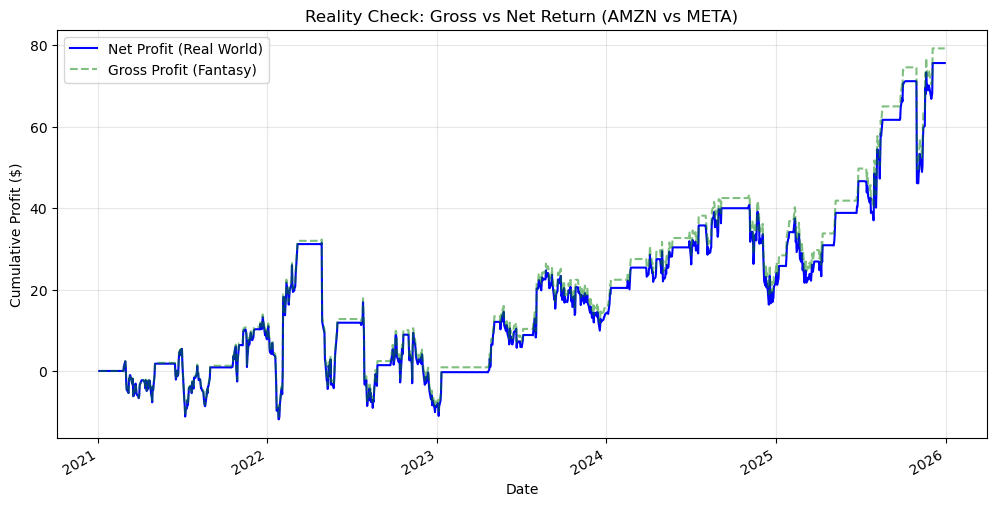

Total Gross Profit: $79.26
Total Net Profit:   $75.66


In [8]:
# Raw PnL (Gross)
trades['Spread_Change'] = spread - spread.shift(1)
trades['Gross_PnL'] = trades['Position'].shift(1) * trades['Spread_Change']

# TRANSACTION COSTS
# We assume a cost of 0.1% (0.001) of the asset price per trade.
# Cost = $0.05 per share traded per side.
cost_per_trade = 0.05 

# Detect when trades happen: 
# If position changes from 0 to 1, or 1 to 0, that's a transaction.
trades['Trade_Count'] = trades['Position'].diff().abs() 
trades['Transaction_Costs'] = trades['Trade_Count'] * cost_per_trade

# Net PnL
trades['Net_PnL'] = trades['Gross_PnL'] - trades['Transaction_Costs']

# Plotting
plt.figure(figsize=(12, 6))
trades['Net_PnL'].cumsum().plot(color='blue', label='Net Profit (Real World)')
trades['Gross_PnL'].cumsum().plot(color='green', linestyle='--', alpha=0.5, label='Gross Profit (Fantasy)')

plt.title(f"Reality Check: Gross vs Net Return ({stock1} vs {stock2})")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total Gross Profit: ${trades['Gross_PnL'].sum():.2f}")
print(f"Total Net Profit:   ${trades['Net_PnL'].sum():.2f}")

--- STRATEGY REPORT CARD ---
Total Net Profit:    $75.66
Sharpe Ratio:        0.46
Max Drawdown:        -0.42%


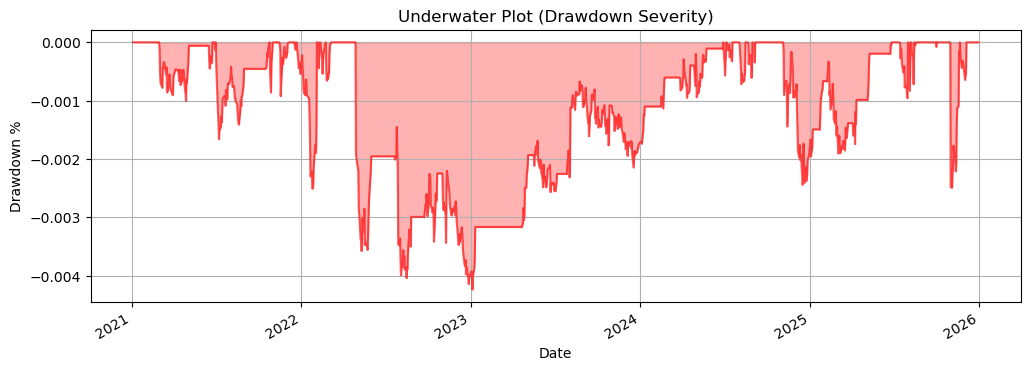

In [9]:
# --- FINAL PERFORMANCE METRICS ---

# 1. PREPARE THE DATA
# We need the "Net" Daily Returns (percentage), not dollar PnL
# Assuming we started with $10,000 capital (just for percentage calculation)
initial_capital = 10000
trades['Equity'] = initial_capital + trades['Net_PnL'].cumsum()
trades['Daily_Return_Pct'] = trades['Equity'].pct_change()

# 2. CALCULATE SHARPE RATIO
# Formula: (Mean Return / Volatility) * sqrt(252 trading days)
risk_free_rate = 0.0 # Assuming 0 for simplicity
daily_mean = trades['Daily_Return_Pct'].mean()
daily_vol = trades['Daily_Return_Pct'].std()

sharpe_ratio = (daily_mean / daily_vol) * (252 ** 0.5)

# 3. CALCULATE MAX DRAWDOWN
# Calculate the "Running High" (Peak Equity)
trades['Peak_Equity'] = trades['Equity'].cummax()

# Calculate how far we are from the peak (percentage)
trades['Drawdown'] = (trades['Equity'] - trades['Peak_Equity']) / trades['Peak_Equity']
max_drawdown = trades['Drawdown'].min()

# 4. PRINT REPORT CARD
print("--- STRATEGY REPORT CARD ---")
print(f"Total Net Profit:    ${trades['Net_PnL'].sum():.2f}")
print(f"Sharpe Ratio:        {sharpe_ratio:.2f}")
print(f"Max Drawdown:        {max_drawdown*100:.2f}%")

# 5. VISUALIZE THE PAIN (Drawdown Chart)
plt.figure(figsize=(12, 4))
trades['Drawdown'].plot(color='red', alpha=0.6, fillstyle='bottom')
plt.fill_between(trades.index, trades['Drawdown'], color='red', alpha=0.3)
plt.title("Underwater Plot (Drawdown Severity)")
plt.ylabel("Drawdown %")
plt.grid()
plt.show()